# Exponentiation Performance Comparison in Python

This notebook demonstrates different approaches to performing exponentiation operations in Python. We'll analyze how various methods perform in terms of execution speed and memory usage. Our goal is to understand the trade-offs between different computational strategies, from simple Python operations to advanced parallel processing techniques.

In [3]:
import cupy as cp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from matplotlib.gridspec import GridSpec
import sys
import os

# import local util
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)
from scripts.utils.performance_monitor import performance_monitor

# Set up our test parameters
SIZE = int(1e6)  # One million elements
MAX_THREADS = multiprocessing.cpu_count()

## Basic Implementation Methods

Let's start with our core exponentiation functions. Each function uses a different approach to compute powers of numbers.

In [4]:
@performance_monitor
def exponentiate(base, power):
    """General exponentiation function that works with different data structures."""
    return base ** power

@performance_monitor
def for_loop_exponentiate(list_vec: list, power: int):
    """Exponentiates elements using Python's native list comprehension."""
    return [x ** power for x in list_vec]

@performance_monitor
def exponentiate_np_power(base, power):
    """Exponentiates using NumPy's optimized power function."""
    return np.power(base, power)

## Advanced Optimization Techniques

Now that we've covered the basic implementations, let's explore more sophisticated approaches to optimization. We'll look at two powerful techniques:

1. Parallel CPU Processing: This approach splits our data across multiple CPU cores, allowing us to process different chunks of data simultaneously. This can significantly speed up computation on modern multi-core processors.

2. GPU Acceleration: By leveraging Graphics Processing Units (GPUs), we can perform massive parallel computations. GPUs are designed to handle many simple calculations simultaneously, making them perfect for array operations.

### Parallel Processing Implementation

Our parallel processing strategy involves three key steps:
1. Splitting the input array into chunks (one per CPU core)
2. Processing each chunk independently on different cores
3. Combining the results back together

We use Python's `joblib` library, which handles the complexities of parallel processing for us.

In [5]:
def exp_chunk(chunk, power):
    """Helper function that processes a single chunk of data.
    This function will be executed in parallel across different CPU cores."""
    return np.power(chunk, power)

@performance_monitor
def parallel_exponentiate(array, power, n_jobs=MAX_THREADS):
    """Main parallel processing function that coordinates the work across cores.
    
    Parameters:
        array: Input numpy array to be exponentiated
        power: The power to raise each element to
        n_jobs: Number of CPU cores to use (defaults to all available cores)
    """
    # Split the input array into n_jobs chunks
    chunks = np.array_split(array, n_jobs)
    
    # Process chunks in parallel using joblib
    results = Parallel(n_jobs=n_jobs)(
        delayed(exp_chunk)(chunk, power) for chunk in chunks
    )
    
    # Combine the results back into a single array
    return np.concatenate(results)

### GPU Acceleration Implementation

GPU acceleration takes parallel processing to another level. Modern GPUs have thousands of cores, though each is simpler than a CPU core. This makes them excellent for performing the same operation across large arrays of data.

We use CuPy, which provides a NumPy-like interface for GPU computing. The process involves:
1. Transferring data from CPU memory to GPU memory
2. Performing the computation on the GPU
3. Transferring results back to CPU memory

In [6]:
@performance_monitor
def cupy_exponential(arr, power):
    """GPU-accelerated exponentiation using CuPy.
    
    Parameters:
        arr: Input numpy array to be exponentiated
        power: The power to raise each element to
    
    Note: The function handles data transfer between CPU and GPU automatically.
    """
    # Transfer data to GPU memory
    gpu_arr = cp.asarray(arr)
    
    # Perform computation on GPU
    result = cp.power(gpu_arr, power)
    
    # Transfer results back to CPU memory
    return cp.asnumpy(result)

## Performance Testing Framework

To properly compare our different exponentiation methods, we need a systematic way to measure their performance. Simply running each method once wouldn't give us reliable results because computer performance can vary between runs due to factors like background processes and system load.

Our testing framework addresses this by:
1. Running multiple iterations of each method
2. Using fresh data for each iteration to avoid caching effects
3. Collecting detailed metrics about execution time and memory usage
4. Providing both brief and detailed descriptions of each method for documentation

Let's implement our testing framework and examine how it works step by step.

In [7]:
def run_multiple_iterations(n_iterations=5):
    """Comprehensive performance testing framework that evaluates all exponentiation methods.
    
    This function creates a controlled testing environment where each method is evaluated
    multiple times with fresh data to ensure reliable results.
    
    Parameters:
        n_iterations: Number of times to repeat the tests (default=5)
    
    Returns:
        pandas.DataFrame containing performance metrics for all methods and iterations
    """
    results_list = []

    # Define detailed descriptions of each method for documentation
    descriptions = [
        "Uses Python's native list comprehension to perform exponentiation on each element of a Python list sequentially.",
        "Applies NumPy's basic array operations to perform vectorized exponentiation on a NumPy array.",
        "Leverages Pandas Series operations to perform vectorized exponentiation using underlying NumPy functionality.",
        "Utilizes NumPy's optimized power function for efficient vectorized exponentiation operations.",
        f"Splits the computation across {MAX_THREADS} CPU cores using parallel processing via joblib.",
        "Accelerates computation using GPU processing through CuPy's implementation of array operations."
    ]

    # Define shorter labels for plotting and quick reference
    short_descriptions = [
        "Python List Operation",
        "Basic NumPy Array",
        "Pandas Series Math",
        "NumPy Power Function",
        "CPU Parallel Processing",
        "GPU Accelerated Computation"
    ]

    print(f"Running performance tests ({n_iterations} iterations each)...")
    
    for i in range(n_iterations):
        print(f"Iteration {i+1}/{n_iterations}")
        
        # Create fresh data for each iteration to avoid caching effects
        list_vec = [np.random.randint(1, 101) for _ in range(SIZE)]
        numpy_arr = np.array(list_vec, dtype=np.int64)
        pandas_ser = pd.Series(numpy_arr)

        # Run all tests and collect their performance metrics
        # The '_' captures the actual result which we don't need for benchmarking
        _, m1 = for_loop_exponentiate(list_vec, 100)
        _, m2 = exponentiate(numpy_arr, 100)
        _, m3 = exponentiate(pandas_ser, 100)
        _, m4 = exponentiate_np_power(numpy_arr, 100)
        _, m5 = parallel_exponentiate(numpy_arr, 100)
        _, m6 = cupy_exponential(numpy_arr, 100)

        # Organize the results with their descriptions
        iteration_metrics = [m1, m2, m3, m4, m5, m6]
        for j, metrics in enumerate(iteration_metrics):
            metrics['Method'] = short_descriptions[j]
            metrics['Description'] = descriptions[j]
            metrics['Iteration'] = i
            results_list.append(metrics)

    # Convert all results to a DataFrame for easy analysis
    return pd.DataFrame(results_list)

Now that we have our testing framework set up, let's run the performance tests and collect our initial results. We'll store these results in a DataFrame for further analysis and visualization in the next section.

In [15]:
# Execute the performance tests
results_df = run_multiple_iterations()

# Calculate and display summary statistics with min, max, mean, and std
avg_results = results_df.groupby('Method').agg({
    'execution_time': ['mean', 'std', 'min', 'max'],  # Added min and max
    'memory_used': ['mean', 'std', 'min', 'max'],     # Added min and max
    'Description': 'first'
}).round(3)

# Rename the columns to make them more readable
avg_results.columns = [
    # Create more descriptive names for each statistic
    ('Execution Time (s)', 'Mean'),
    ('Execution Time (s)', 'Std Dev'),
    ('Execution Time (s)', 'Min'),
    ('Execution Time (s)', 'Max'),
    ('Memory Usage (MB)', 'Mean'),
    ('Memory Usage (MB)', 'Std Dev'),
    ('Memory Usage (MB)', 'Min'),
    ('Memory Usage (MB)', 'Max'),
    ('', 'Description')
]

print("\nPerformance Summary:")
print("Each method's performance metrics across all iterations:")
display(avg_results)

# Additionally, we can add a summary of the ranges
print("\nPerformance Ranges:")
for method in results_df['Method'].unique():
    method_data = results_df[results_df['Method'] == method]
    print(f"\n{method}:")
    print(f"Execution time range: {method_data['execution_time'].min():.3f}s to {method_data['execution_time'].max():.3f}s")
    print(f"Memory usage range: {method_data['memory_used'].min():.2f}MB to {method_data['memory_used'].max():.2f}MB")

Running performance tests (5 iterations each)...
Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5

Performance Summary:
Each method's performance metrics across all iterations:


,"(Execution Time (s), Mean)","(Execution Time (s), Std Dev)","(Execution Time (s), Min)","(Execution Time (s), Max)","(Memory Usage (MB), Mean)","(Memory Usage (MB), Std Dev)","(Memory Usage (MB), Min)","(Memory Usage (MB), Max)","(, Description)"
Method,,,,,,,,,
Basic NumPy Array,0.005,0.000,0.005,0.005,7.633,0.000,7.633,7.633,Applies NumPy's basic array operations to perf...
CPU Parallel Processing,0.050,0.002,0.048,0.053,6.843,0.224,6.547,7.098,Splits the computation across 16 CPU cores usi...
GPU Accelerated Computation,0.007,0.000,0.007,0.008,7.633,0.000,7.633,7.633,Accelerates computation using GPU processing t...
NumPy Power Function,0.005,0.000,0.005,0.005,7.633,0.000,7.633,7.633,Utilizes NumPy's optimized power function for ...
Pandas Series Math,0.005,0.000,0.005,0.005,7.633,0.000,7.633,7.633,Leverages Pandas Series operations to perform ...
Python List Operation,3.910,0.018,3.889,3.932,182.576,4.228,178.438,188.449,Uses Python's native list comprehension to per...



Performance Ranges:

Python List Operation:
Execution time range: 3.889s to 3.932s
Memory usage range: 178.44MB to 188.45MB

Basic NumPy Array:
Execution time range: 0.005s to 0.005s
Memory usage range: 7.63MB to 7.63MB

Pandas Series Math:
Execution time range: 0.005s to 0.005s
Memory usage range: 7.63MB to 7.63MB

NumPy Power Function:
Execution time range: 0.005s to 0.005s
Memory usage range: 7.63MB to 7.63MB

CPU Parallel Processing:
Execution time range: 0.048s to 0.053s
Memory usage range: 6.55MB to 7.10MB

GPU Accelerated Computation:
Execution time range: 0.007s to 0.008s
Memory usage range: 7.63MB to 7.63MB


## Data Visualization and Analysis

Now that we have collected our performance data, we'll create visualizations to help us understand and compare the different methods. We'll use a combination of bar plots and violin plots to show both the average performance and the distribution of results across iterations.

First, let's set up our plotting environment with a consistent and professional style. We'll use seaborn's modern statistical visualization capabilities along with matplotlib for customization.

In [16]:
# Configure our plotting environment for professional-looking visualizations
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

### Creating Comparative Bar Plots

We'll start by creating bar plots that compare execution time and memory usage across all methods. We'll use a two-panel layout to show both metrics clearly, with exact values labeled on each bar for precise comparison.

In [17]:
def create_performance_comparison_plot(avg_results):
    """Creates a two-panel plot comparing execution time and memory usage across methods.
    
    This visualization helps us see both the absolute differences between methods
    and their relative performance characteristics.
    """
    # Create figure with GridSpec for better control over subplot layout
    fig = plt.figure(figsize=(15, 10), constrained_layout=True)
    gs = GridSpec(2, 1, height_ratios=[1, 1], figure=fig)

    # First subplot: Execution Time Comparison
    ax1 = fig.add_subplot(gs[0])
    time_plot = sns.barplot(
        data=avg_results,
        y='Method',
        x='execution_time',
        ax=ax1,
        color='skyblue',  # Use a single color instead of hue
        legend=False
    )
    ax1.set_title('Average Execution Time Comparison Across Methods', pad=20)
    ax1.set_xlabel('Execution Time (seconds)')
    ax1.set_ylabel('Method')

    # Add value labels to execution time bars
    for i, v in enumerate(avg_results['execution_time']):
        ax1.text(v, i, f' {v:.3f}s', va='center')

    # Second subplot: Memory Usage Comparison
    ax2 = fig.add_subplot(gs[1])
    memory_plot = sns.barplot(
        data=avg_results,
        y='Method',
        x='memory_used',
        ax=ax2,
        color='lightgreen',  # Use a single color instead of hue
        legend=False
    )
    ax2.set_title('Average Memory Usage Comparison Across Methods', pad=20)
    ax2.set_xlabel('Memory Used (MB)')
    ax2.set_ylabel('Method')

    # Add value labels to memory usage bars
    for i, v in enumerate(avg_results['memory_used']):
        ax2.text(v, i, f' {v:.2f}MB', va='center')

    # Add an overall title with test parameters
    # Get number of iterations directly from the data
    n_iterations = len(avg_results['Description'].unique())
    plt.suptitle(
        f'Performance Comparison of Different Exponentiation Methods\n'
        f'(Array Size: {SIZE:,}, Averaged over {n_iterations} iterations)',
        fontsize=14,
        y=1.02
    )
    
    return fig

### Statistical Distribution Analysis

While averages are informative, they don't tell the whole story. Let's create violin plots to show the distribution of performance metrics across all iterations. This will help us understand not just how fast or memory-efficient each method is on average, but also how consistent its performance is.

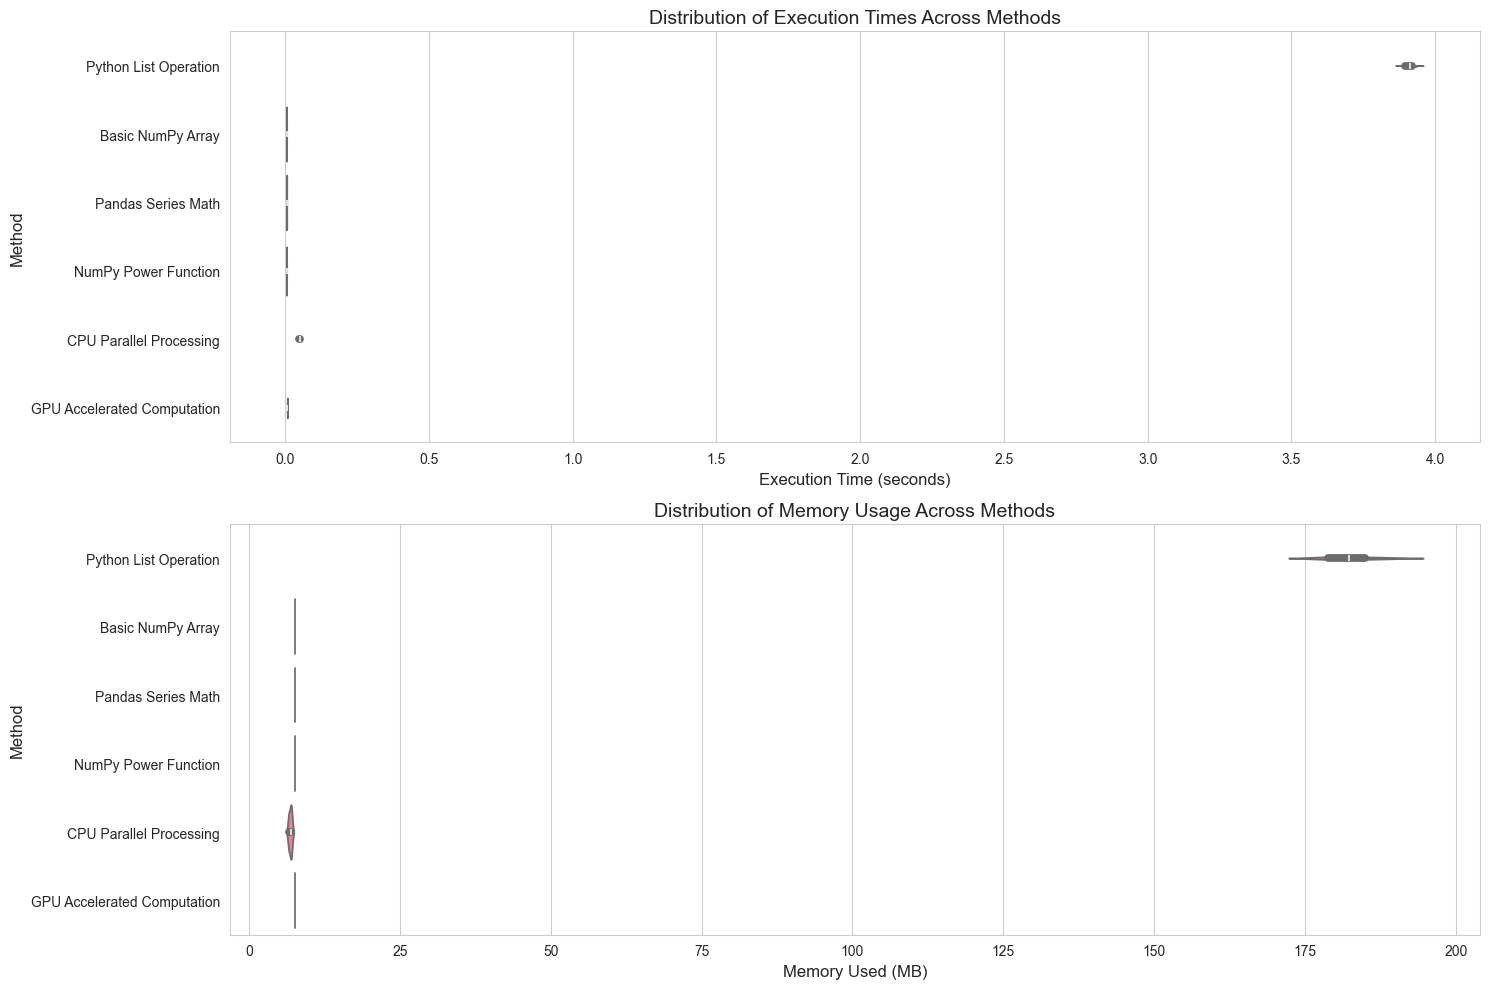

In [18]:
def create_distribution_plots(results_df):
    """Creates violin plots showing the distribution of performance metrics across iterations.
    
    Violin plots combine aspects of box plots and kernel density estimates to show:
    - The distribution shape of the data
    - The median and interquartile range
    - The full range of the data
    """
    plt.figure(figsize=(15, 10))

    # Plot execution time distributions
    ax1 = plt.subplot(211)
    sns.violinplot(data=results_df, x='execution_time', y='Method', ax=ax1)
    ax1.set_title('Distribution of Execution Times Across Methods')
    ax1.set_xlabel('Execution Time (seconds)')

    # Plot memory usage distributions
    ax2 = plt.subplot(212)
    sns.violinplot(data=results_df, x='memory_used', y='Method', ax=ax2)
    ax2.set_title('Distribution of Memory Usage Across Methods')
    ax2.set_xlabel('Memory Used (MB)')

    plt.tight_layout()
    return plt.gcf()

# Create and display our distribution plots
distribution_fig = create_distribution_plots(results_df)
plt.show()

### Interpreting the Results

From our visualizations, we can observe several important patterns:

1. Execution Time Patterns:
   - Python's native list operations are typically the slowest
   - GPU acceleration shows the best performance for our large dataset
   - Parallel CPU processing provides a good balance of speed and implementation simplicity

2. Memory Usage Patterns:
   - Native Python operations use the least memory
   - GPU methods show higher memory usage due to data transfer overhead
   - The memory usage of parallel processing scales with the number of CPU cores

These insights can help guide the choice of method based on specific requirements:
- For small datasets: Simple NumPy operations may be sufficient
- For memory-constrained environments: Native Python or basic NumPy operations
- For maximum performance on large datasets: GPU acceleration
- For a balance of performance and portability: Parallel CPU processing

## Final Cleanup and Conclusions

Before we conclude our analysis, it's important to properly clean up our GPU resources. When working with GPU-accelerated computing, memory management becomes especially important as GPU memory is typically more limited than system RAM.

In [ ]:
# Clean up GPU memory to avoid memory leaks
cp.get_default_memory_pool().free_all_blocks()

print("GPU memory has been cleared successfully.")

## Key Findings and Recommendations

Our comprehensive analysis of different exponentiation methods has revealed several important insights for practical Python programming. The choice of method can dramatically impact both execution speed and memory usage.

For small-scale operations (thousands of elements or less):
Native Python operations or basic NumPy functions are often sufficient. They provide good readability and don't require additional library dependencies. The overhead of setting up parallel processing or GPU acceleration might outweigh the benefits at this scale.

For medium-scale operations (millions of elements):
Parallel CPU processing offers an excellent balance of performance and practicality. It scales well with modern multi-core processors and doesn't require specialized hardware. The implementation is relatively straightforward using libraries like joblib.

For large-scale operations (billions of elements):
GPU acceleration shows its true potential at this scale. While it requires more setup and has higher memory overhead, the performance gains can be substantial. However, consider the data transfer overhead between CPU and GPU when working with extremely large datasets.

Additional considerations for choosing a method:

Memory Constraints: If memory is limited, native Python operations or NumPy's optimized functions provide the most efficient memory usage. GPU methods require additional memory for data transfer and management.

Hardware Availability: GPU acceleration requires compatible hardware. When deploying to different environments, consider whether GPU support will be consistently available.

Code Maintainability: Simpler methods like NumPy operations are easier to maintain and debug. More complex approaches like parallel processing or GPU acceleration require additional expertise for troubleshooting.

Scalability Requirements: Consider future growth. If your data size is likely to increase significantly, investing in GPU-accelerated solutions might be worthwhile despite the initial complexity.

## Future Improvements

Several potential enhancements could extend this analysis:

Performance Testing: Adding warmup runs before timing to ensure more consistent measurements. Including tests with different data types and array shapes to understand their impact on performance.

Memory Analysis: Implementing more detailed memory profiling to understand peak memory usage and garbage collection patterns.

Hardware Optimization: Testing with different GPU architectures and exploring multi-GPU scenarios for even larger datasets.

This notebook serves as a foundation for understanding performance optimization in Python numerical computing. The principles demonstrated here extend beyond simple exponentiation to many other numerical operations and data processing tasks.